In [48]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Input, Flatten, concatenate
from keras import Model
import pandas as pd
import matplotlib.pyplot as plt

### Create layer architecture as specified in diagram

#### 8 Inputs:
- From Visible Image
    - Laplacian Variance (Scalar)
    - DCT Power Spectrum in the x-axis (1D Array)
    - DCT Power Spectrum in the y-axis (1D Array)
- From Infrared Image
    - Laplacian Variance (Scalar)
    - DCT Power Spectrum in the x-axis (1D Array)
    - DCT Power Spectrum in the y-axis (1D Array)
- From Lidar Point Cloud
    - Pings vs. Depth Distribution (1D Array)
    - Depth Map (2D Matrix)

Abbreivations:
- Laplacian Variance --> lapVar
- DCT Power Spectrums --> dctPowerX, dctPowerY
- Lidar Pings vs. Depth Distribution --> pingDist
- Depth Map --> depthMap

### Parameters

In [49]:
dctPowerX_length = int(512/2)+1
dctPowerY_length = int(640/2)+1
pingDist_length = 100
depthMap_length = 25*20

### Visible Inputs

In [50]:
visible_lapVar = Input(shape=(1,),  # Scalar
                       name="Visible_Laplacian_Variance",
                       dtype="float32")

visible_dctPowerX = Input(shape=(dctPowerX_length-2,), # 1D array
                          name="Visible_Power_Spectrum_X",
                          dtype="float32")

visible_dctPowerY = Input(shape=(dctPowerY_length,), # 1D array
                          name="Visible_Power_Spectrum_Y",
                          dtype="float32")

# Combine all 3 inputs into 1 layer
visibleCombined = concatenate([visible_lapVar,
                               visible_dctPowerX,
                               visible_dctPowerY],
                               name="Combined_Visible")

### Infrared Inputs

In [51]:
infrared_lapVar = Input(shape=(1,),  # Scalar
                       name="Infrared_Laplacian_Variance",
                       dtype="float32")

infrared_dctPowerX = Input(shape=(dctPowerX_length,), # 1D array
                          name="Infrared_Power_Spectrum_X",
                          dtype="float32")

infrared_dctPowerY = Input(shape=(dctPowerY_length,), # 1D array
                          name="Infrared_Power_Spectrum_Y",
                          dtype="float32")

# Combine all 3 inputs into 1 layer
infraredCombined = concatenate([infrared_lapVar,
                               infrared_dctPowerX,
                               infrared_dctPowerY],
                               name="Combined_Infrared")

### Lidar Inputs

In [52]:
lidar_pingDist= Input(shape=(pingDist_length,),  # 1D array
                      name="Lidar_Ping_Distribution",
                      dtype="float32")

lidar_depthMap = Input(shape=depthMap_length, # 2D array flattened into 1D
                       name="Lidar_Depth_Map",
                       dtype="float32")

# Flatten depth map into 1D
# lidar_depthMapFlat = Flatten()(lidar_depthMap)

# Combine all 2 inputs into 1 layer
lidarCombined = concatenate([lidar_pingDist,
                             lidar_depthMap],
                             name="Combined_Lidar")

### "Intermediary" dense layers for each instrument

Prior to combining the data from all three cameras (visible, infrared, and
Lidar), there will be a three dense layers that train on each camera
individually. We hope this will better summarize the three data streams prior
to combining all of them together.

In [53]:
neuronsPerLayer = 32  # Hm...

visibleDense = Dense(units=neuronsPerLayer,
                     activation="sigmoid",
                     name="Visible_Dense_Layer")(visibleCombined)

infraredDense = Dense(units=neuronsPerLayer,
                      activation="sigmoid",
                      name="Infrared_Dense_Layer")(infraredCombined)

lidarDense = Dense(units=neuronsPerLayer,
                      activation="sigmoid",
                      name="Lidar_Dense_Layer")(lidarCombined)

allImageryCombined = concatenate([visibleDense,
                                  infraredDense,
                                  lidarDense],
                                  name="Combined_Neurons")

### More Dense Layers

Now that we have the imagery inputs in three separate dense layers, we can now feed these layers into more dense layers that integrate the data held by all instruments.

How many layers are optimal for neural network training? There is no good, analytical way to determine this, but we will choose use 3 for our model. The number of neurons will decrease for the layers closer to the output, as the weights in the third layer should have more refinement and than the first layer.

We will use the relu (rectified linear unit) activiation function, as this is the most basic activiation function and does not suffer from the vanishing gradient problem (cite this too).

Future work could run a parameter study with the number of layers, the number of neurons within each layer, and the activiation function to determine the optimum configuration.

https://www.v7labs.com/blog/neural-networks-activation-functions#h5


In [54]:
neuronsInLayers = [64, 32, 16]  # This are arbitrarily-picked values

firstDense = Dense(units=neuronsInLayers[0],
                   activation="sigmoid",
                   name="First_Dense_Layer")(allImageryCombined)

secondDense = Dense(units=neuronsInLayers[1],
                   activation="sigmoid",
                   name="Second_Dense_Layer")(firstDense)

thirdDense = Dense(units=neuronsInLayers[2],
                   activation="sigmoid",
                   name="Third_Dense_Layer")(secondDense)

### Output Layer

Our neural network will have two outputs (neurons): the ML-derived estimate for meteorological optical range (MOR) and liquid water content (LWC) of the environment that was captured with the visible, infrared, and lidar cameras.

We will use the Relu activation function again (instead of the linear activation function), as both MOR and LWC cannot be negative. In other words, an estimate of 0 (lower bound of Relu) is better than any negative estimate (lower bound of linear).

https://towardsdatascience.com/deep-learning-which-loss-and-activation-functions-should-i-use-ac02f1c56aa8

In [55]:
estimates = Dense(2,
                  activation="selu",
                  name="MOR_and_LWC_estimates")(thirdDense)

### Putting everything together...

In [56]:
neuralNetwork = Model(
                      inputs=[visible_lapVar,
                              visible_dctPowerX,
                              visible_dctPowerY,
                              infrared_lapVar,
                              infrared_dctPowerX,
                              infrared_dctPowerY,
                              lidar_pingDist,
                              lidar_depthMap],
                      outputs=estimates
)

### Visualize Path of Data Through Neural Network

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Visible_Laplacian_Variance (In  [(None, 1)]         0           []                               
 putLayer)                                                                                        
                                                                                                  
 Visible_Power_Spectrum_X (Inpu  [(None, 255)]       0           []                               
 tLayer)                                                                                          
                                                                                                  
 Visible_Power_Spectrum_Y (Inpu  [(None, 321)]       0           []                               
 tLayer)                                                                                    

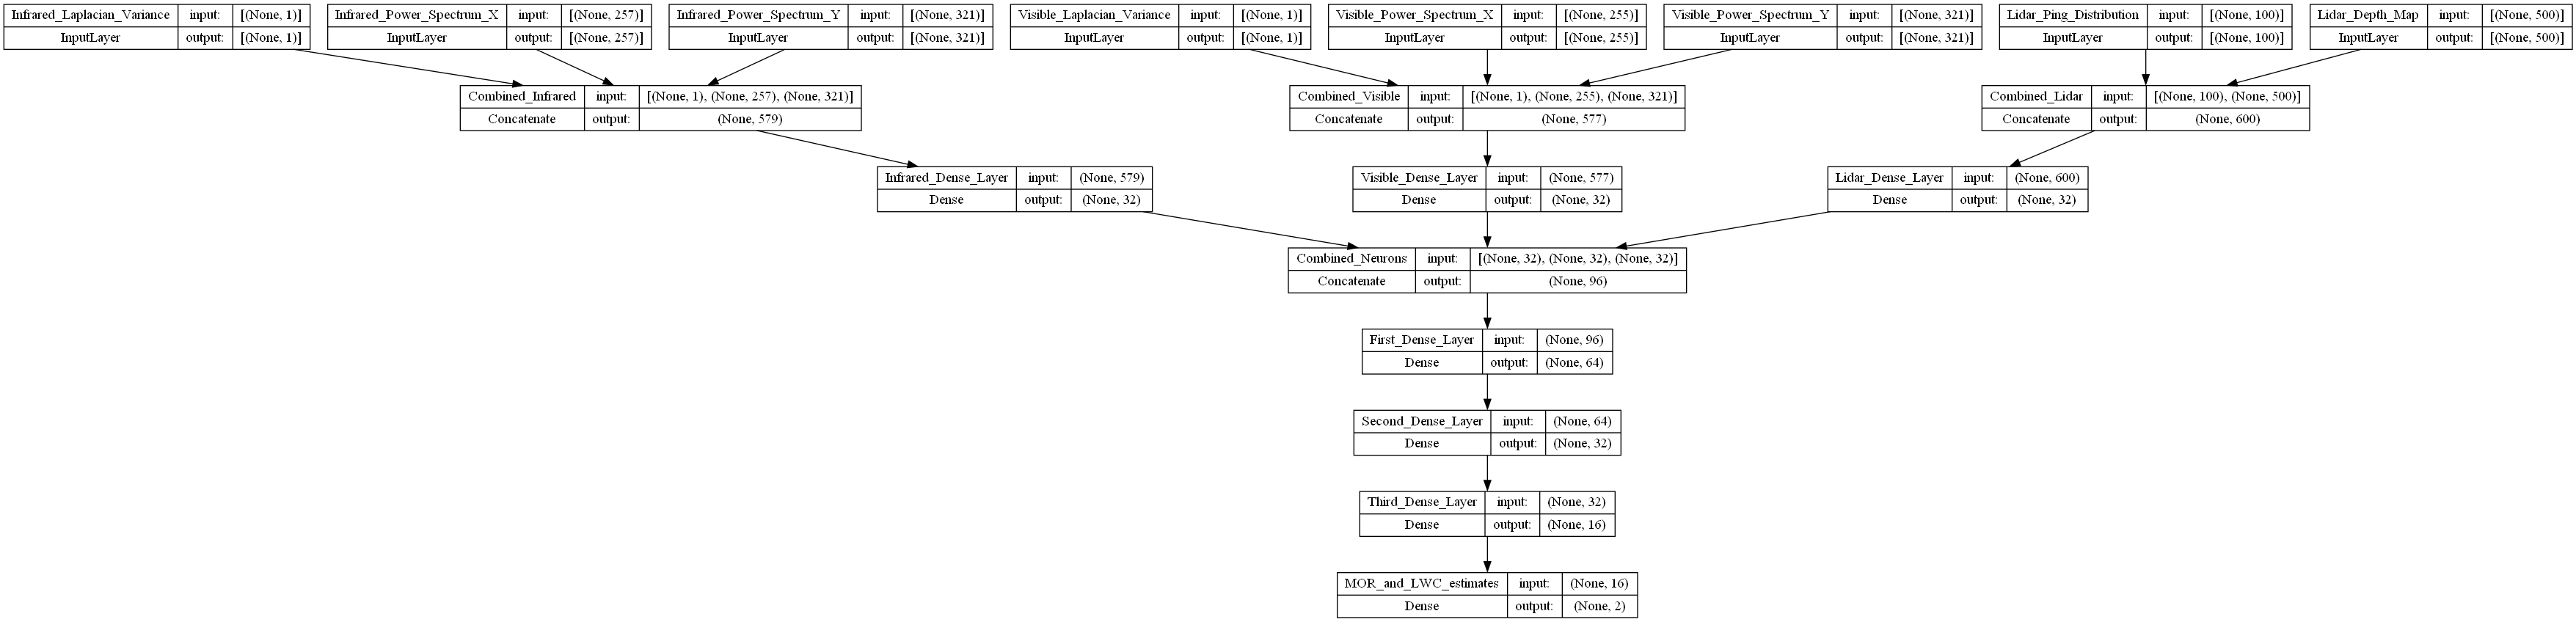

In [57]:
neuralNetwork.summary()
keras.utils.plot_model(neuralNetwork, show_shapes=True)

### Compile the Neural Network

Add the loss function and optimizer.

In [68]:
neuralNetwork.compile(loss="mean_absolute_percentage_error",
                      optimizer="adam",
                      metrics=['mean_squared_error'])

### Load in the data

In [59]:
# Dummy input data
'''
numCorrelatedImages = 500

fakeLidarDepthMap = np.random.rand(numCorrelatedImages, depthMap_dimensions[0], depthMap_dimensions[1])
fakeLidarPingDist = np.random.rand(numCorrelatedImages, pingDist_length)

fakeVisibleLapVar = np.random.rand(numCorrelatedImages)
fakeVisibleDCT_X = np.random.rand(numCorrelatedImages, dctPowerX_length)
fakeVisibleDCT_Y = np.random.rand(numCorrelatedImages, dctPowerY_length)

fakeInfraredLapVar = np.random.rand(numCorrelatedImages)
fakeInfraredDCT_X = np.random.rand(numCorrelatedImages, dctPowerX_length)
fakeInfraredDCT_Y = np.random.rand(numCorrelatedImages, dctPowerY_length)

inputs = {"Lidar_Depth_Map": fakeLidarDepthMap,
          "Lidar_Ping_Distribution": fakeLidarPingDist,
          "Visible_Laplacian_Variance": fakeVisibleLapVar,
          "Visible_Power_Spectrum_X": fakeVisibleDCT_X,
          "Visible_Power_Spectrum_Y": fakeVisibleDCT_Y,
          "Infrared_Laplacian_Variance": fakeInfraredLapVar,
          "Infrared_Power_Spectrum_X": fakeInfraredDCT_X,
          "Infrared_Power_Spectrum_Y": fakeInfraredDCT_Y,}

outputs = {"MOR_and_LWC_estimates": np.random.rand(numCorrelatedImages, 2)}
'''

# Load in actual data
from NN_Functions import getFog16Data

# Get fog16 data
(train_set, test_set) = getFog16Data()

Train the Neural Network!

In [69]:

'''
history = neuralNetwork.fit(inputs,
                            outputs,
                            epochs=1000,
                            batch_size=64,  # Number of images to process per weight-update
                            validation_split=0.2  # Fraction of training data used exclusively for loss evaluation at the end of every epoch
)
'''

history = neuralNetwork.fit(train_set['inputs'], train_set['outputs'],
                            epochs=500, # Pick some random number lmao
                            batch_size=64,  # Number of images to process per weight-update, typically a power of 2
)

Epoch 1/500
42/42 [==============================] - 1s 4ms/step - loss: 3.8754 - mean_squared_error: 4.8214
Epoch 2/500
42/42 [==============================] - 0s 4ms/step - loss: 3.4431 - mean_squared_error: 2.8107
Epoch 3/500
42/42 [==============================] - 0s 4ms/step - loss: 3.3746 - mean_squared_error: 2.8865
Epoch 4/500
42/42 [==============================] - 0s 4ms/step - loss: 3.3662 - mean_squared_error: 2.9316
Epoch 5/500
42/42 [==============================] - 0s 4ms/step - loss: 3.6061 - mean_squared_error: 3.4156
Epoch 6/500
42/42 [==============================] - 0s 4ms/step - loss: 3.3029 - mean_squared_error: 2.8907
Epoch 7/500
42/42 [==============================] - 0s 3ms/step - loss: 3.3871 - mean_squared_error: 3.0773
Epoch 8/500
42/42 [==============================] - 0s 4ms/step - loss: 3.4411 - mean_squared_error: 2.9917
Epoch 9/500
42/42 [==============================] - 0s 4ms/step - loss: 3.3190 - mean_squared_error: 2.8786
Epoch 10/500
42/42 

In [71]:
# Fit test data
trainAnswers = neuralNetwork.predict(train_set["inputs"])
testAnswers = neuralNetwork.predict(test_set["inputs"])

testAnswers
#np.shape(testAnswers)

20/20 [==============================] - 0s 3ms/step


array([[6.6654114e+01, 9.3038328e-02],
       [4.8260101e+01, 1.2871490e-01],
       [4.8332340e+01, 1.4747027e-01],
       ...,
       [1.4391153e+02, 1.6149937e-01],
       [1.4707802e+02, 1.6117853e-01],
       [1.4767319e+02, 1.6133547e-01]], dtype=float32)

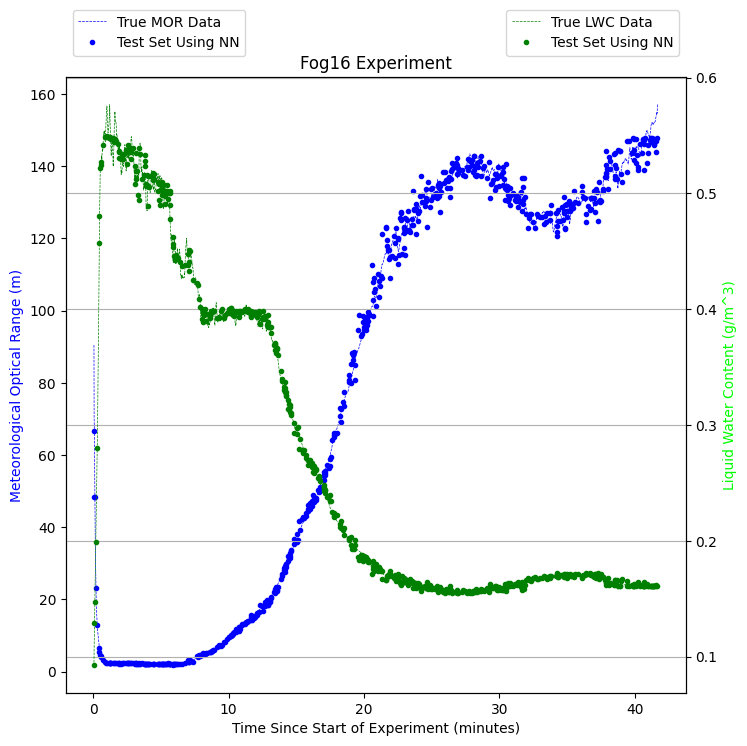

In [72]:
# Plot "real" fog16 data
boxFolder = "c:\\Users\\andy1\\Box\\"
csvsPath = boxFolder + "Glenn I Data\Csvs for Neural Network\\"
df = pd.read_csv(csvsPath + "fog16_data_withLapVars.csv")


fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()

# Plot initialization
plt.grid(True, which="both")
ax1.set_xlabel("Time Since Start of Experiment (minutes)")
ax1.set_title("Fog16 Experiment")

ax1.set_ylabel("Meteorological Optical Range (m)", color=[0, 0, 1])
ax2.set_ylabel("Liquid Water Content (g/m^3)", color=[0,1,0])

# Plot ground truth
ax1.plot(df["timeSinceStart"]/60, df["MOR532_m_filt"], "b--", linewidth=0.5)
ax2.plot(df["timeSinceStart"]/60, df["LWC_gm3_filt"], "g--", linewidth=0.5)

# Plot training data after training
#ax1.plot(df.loc[train_set['indexes'], "timeSinceStart"]/60, trainAnswers[:, 0], "b.")
#ax2.plot(df.loc[train_set['indexes'], "timeSinceStart"]/60, trainAnswers[:, 1], "g.")

# Plot test data
ax1.plot(df.loc[test_set['indexes'], "timeSinceStart"]/60, testAnswers[:, 0], "b.")
ax2.plot(df.loc[test_set['indexes'], "timeSinceStart"]/60, testAnswers[:, 1], "g.")

ax1.legend(["True MOR Data", "Test Set Using NN"], bbox_to_anchor=(0, 1.12), loc='upper left')
ax2.legend(["True LWC Data", "Test Set Using NN"], bbox_to_anchor=(1, 1.12), loc='upper right')

INFO:tensorflow:Assets written to: 3-24 Neural Network Post-Training\assets


INFO:tensorflow:Assets written to: 3-24 Neural Network Post-Training\assets


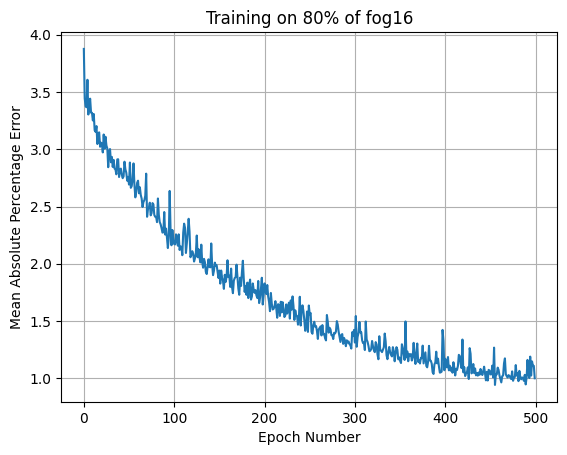

In [75]:
# Plot loss?


plt.grid(True)
plt.plot(history.history['loss'])
plt.xlabel("Epoch Number")
plt.ylabel("Mean Absolute Percentage Error")
plt.title("Training on 80% of fog16")
# plt.text(100, 0.185, "It goes down AYYYY")

# Save the model
neuralNetwork.save("3-24 Neural Network Post-Training")

# To get it back into Python
# readModel = keras.models.load_model("Testing Save Capability")